In [32]:
from typing import Tuple, List, Optional, Dict
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, skew
import pandas as pd
import numpy as np

In [33]:
df = pd.read_csv("../input/metrics_input/Mock_L8_CLI_Qualified_Data.csv")

In [34]:
df.head(1)

,territory_l4_name,territory_l8_name,cli_qualified_within_14d_pct
0,AM-APAC,AM-APAC_1,0.699451


In [36]:
def compute_concentration_scores(
    df: pd.DataFrame,
    metric_col: str,
    higher_is_better: bool = True,
    group_col: str = "territory_l4_name",
    sub_group_col: str = "territory_l8_name",
    global_filter: Optional[str] = "Global",
    p_threshold: float = 10.0,
    std_weight: float = 0.3,
    skew_weight: float = 0.3,
    tail_weight: float = 0.4
) -> Tuple[pd.DataFrame, float]:
    """Compute concentration root cause scores for each L4 region."""
    all_territory_values = df[df[group_col] != global_filter][metric_col].dropna()
    if higher_is_better:
        p10_all_territory = np.percentile(all_territory_values, p_threshold)
    else:
        p10_all_territory = np.percentile(all_territory_values, 100 - p_threshold)
    all_territory_std = np.std(all_territory_values)

    results = []
    for region in df[group_col].unique():
        values = df[df[group_col] == region][metric_col].dropna().values
        if len(values) == 0:
            continue
        std_val = np.std(values)
        skew_val = skew(values)
        if higher_is_better:
            low_ratio = np.mean(values < p10_all_territory)
        else:
            low_ratio = np.mean(values > p10_all_territory)
        score = (
            tail_weight * (low_ratio > 0.3) +
            std_weight * (std_val > all_territory_std) +
            skew_weight * (skew_val < -0.5)
        )
        
        if higher_is_better:
            lagged_sub_regions = df[(df[group_col] == region) & (df[metric_col] < p10_all_territory)] \
                .sort_values(by=metric_col) \
                .iloc[:3] \
                .apply(lambda row: {row[sub_group_col]: row[metric_col]}, axis=1) \
                .tolist()
        else:
            lagged_sub_regions = df[(df[group_col] == region) & (df[metric_col] > p10_all_territory)] \
                .sort_values(by=metric_col, ascending=False) \
                .iloc[:3] \
                .apply(lambda row: {row[sub_group_col]: row[metric_col]}, axis=1) \
                .tolist()

        results.append({
            "region": region,
            "mean": np.mean(values),
            "std": std_val,
            "skew": skew_val,
            "low_l8_ratio": low_ratio,
            "p10_all_territory": p10_all_territory,
            "score": score,
            "lagged_sub_regions": lagged_sub_regions
        })

    return pd.DataFrame(results), p10_all_territory

def _remove_l4_subgroups(df: pd.DataFrame, group_col: str, sub_group_col: str) -> pd.DataFrame:
    """Remove rows where sub_group_col is equal to group_col + ' (l4)'."""
    condition = df[sub_group_col] != (df[group_col] + ' (l4)')
    filtered_df = df[condition].copy()
    return filtered_df

In [ ]:
df = _remove_l4_subgroups(df, 'territory_l4_name', 'territory_l8_name')

df_c, p10 = compute_concentration_scores(df, 'cli_qualified_within_14d_pct', higher_is_better=True, group_col='territory_l4_name', sub_group_col='territory_l8_name', global_filter='Global')

df_c

,region,mean,std,skew,low_l8_ratio,p10_all_territory,score,lagged_sub_regions
0,AM-APAC,0.700264,0.010296,0.278893,0.0,0.513984,0.0,[]
1,AM-EMEA,0.646973,0.011929,-0.388992,0.0,0.513984,0.0,[]
2,AM-LATAM,0.590120,0.013979,0.667938,0.0,0.513984,0.0,[]
3,AM-NA,0.488395,0.054295,-1.080217,0.5,0.513984,0.7,"[{'AM-NA_1': 0.3891123455094963}, {'AM-NA_2': ..."
4,Global,0.650000,0.000000,0.000000,0.0,0.513984,0.0,[]


In [44]:
def plot_region_densities(
    df: pd.DataFrame,
    metric_col: str,
    higher_is_better: bool = True,
    group_col: str = "territory_l4_name",
    p10_all_territory: Optional[float] = None,
    xrange: Tuple[float, float] = (0.35, 0.75),
    results_df: pd.DataFrame = None
):
    """Visualize density distributions per region with global percentile marker."""
    plt.figure(figsize=(10, 6))
    
    # Identify the region with the highest score
    if results_df is not None:
        highest_score_region = results_df.loc[results_df['score'].idxmax()]

    for region in df[group_col].unique():
        values = df[df[group_col] == region][metric_col].dropna()
        # Check if there are enough values to compute density
        if len(values) < 2:
            continue
        
        std_val = np.std(values)
        
        if std_val == 0:
            # Annotate or plot a single point if all values are identical
            plt.axvline(values[0], color='blue', linestyle='--', linewidth=2, label=f"{region} (all values = {values[0]})")
            plt.text(values[0], plt.ylim()[1] * 0.5, f"All values = {values[0]}", 
                     rotation=90, verticalalignment='bottom', fontsize=9, color='blue')
        else:
            density = gaussian_kde(values)
            xs = np.linspace(*xrange, 200)
            plt.plot(xs, density(xs), label=region, linewidth=2)
        
        # Highlight lagged values for the highest score region
        if results_df is not None and region == highest_score_region['region']:
            for lagged_region in highest_score_region['lagged_sub_regions']:
                for sub_region, score in lagged_region.items():
                    plt.axvline(score, color='gray', linestyle='--', linewidth=1)
                    plt.text(score, plt.ylim()[1] * 0.5, f"{sub_region}: {score:.2f}", 
                             rotation=90, verticalalignment='bottom', fontsize=9, color='black')

    if p10_all_territory:
        plt.axvline(p10_all_territory, color="red", linestyle="--", label="Global 10th Percentile")
    
    plt.title(f"Density Plot: {metric_col} by {group_col}")
    plt.xlabel(metric_col.replace("_", " ").title())
    plt.ylabel("Density")
    
    # Remove gridlines
    plt.grid(False)
    
    plt.tight_layout()
    
    # Move the legend outside the plot
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.show()

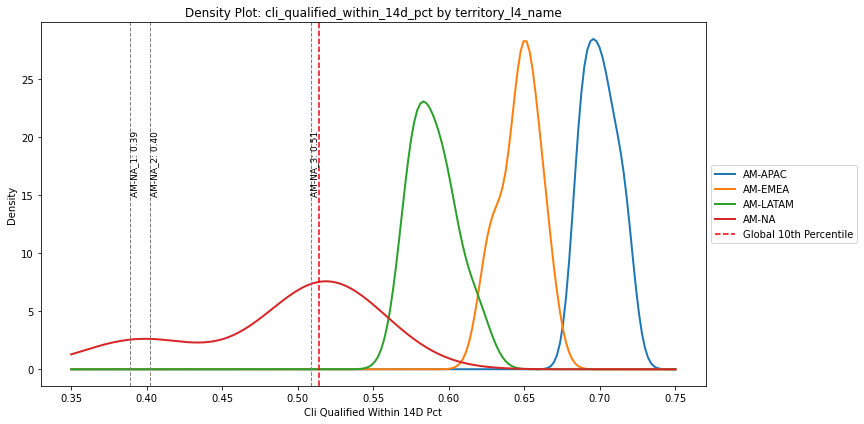

In [45]:
plot_region_densities(
    df = df,
    metric_col = 'cli_qualified_within_14d_pct',
    higher_is_better = True,
    group_col = "territory_l4_name",
    p10_all_territory = compute_concentration_scores(df, 'cli_qualified_within_14d_pct', group_col='territory_l4_name', sub_group_col='territory_l8_name', global_filter='Global')[1],
    xrange = (0.35, 0.75),
    results_df = df_c
)

In [50]:
def generate_insight_template_for_worst_region(results_df: pd.DataFrame, global_std: float, metric_col: str) -> str:
    """Generate an insight template for the worst-performing region based on the results DataFrame."""
    # Identify the region with the lowest score
    worst_region = results_df.loc[results_df['score'].idxmax()]

    region = worst_region['region']
    l4_mean = worst_region['mean']
    std_l4 = worst_region['std']
    skew_l4 = worst_region['skew']
    low_l8_ratio = worst_region['low_l8_ratio']
    skew_trend = "left-skewed" if skew_l4 < 0 else "right-skewed"
    bottom_l8_names = ', '.join([list(lagged.keys())[0] for lagged in worst_region['lagged_sub_regions'][:3]])

    template = f"""
    {region} shows a low {metric_col.replace('_', ' ').title()} (mean: {l4_mean:.3f}), 
    but the distribution suggests the underperformance is **not uniform** across all markets.

    — Std Dev: {std_l4:.3f} (vs global: {global_std:.3f})
    — Skewness: {skew_l4:.2f} → {skew_trend}
    — {low_l8_ratio:.1%} of L8s fall below global 10th percentile

    These indicate that **a few L8s are disproportionately pulling down the regional average**,
    pointing to **localized execution or market challenges** rather than systemic issues.

    ➤ Recommended next step: investigate {region}'s lowest-performing L8s (e.g., {bottom_l8_names}) for localized root causes.
    """
    
    return template

results_df, p10_all_territory = compute_concentration_scores(df, "cli_qualified_within_14d_pct")
global_std = df['cli_qualified_within_14d_pct'].std()
print(generate_insight_template_for_worst_region(results_df, global_std, "cli_qualified_within_14d_pct"))


    AM-NA shows a low Cli Qualified Within 14D Pct (mean: 0.488), 
    but the distribution suggests the underperformance is **not uniform** across all markets.

    — Std Dev: 0.054 (vs global: 0.084)
    — Skewness: -1.08 → left-skewed
    — 50.0% of L8s fall below global 10th percentile

    These indicate that **a few L8s are disproportionately pulling down the regional average**,
    pointing to **localized execution or market challenges** rather than systemic issues.

    ➤ Recommended next step: investigate AM-NA’s lowest-performing L8s (e.g., AM-NA_1, AM-NA_2, AM-NA_3) for localized root causes.
    


In [60]:
import yaml

In [61]:
# Load the tag YAML we just created
with open("../config/closed_lost_reason_tags.yaml") as f:
    reason_yaml = yaml.safe_load(f)

In [114]:
mock_reason_data = [
    {"region": "AM-APAC", "reason": "meta_trust_issues", "opportunity_lost": 1_500_000, "pct_of_total": 0.15},
    {"region": "AM-APAC", "reason": "initiative_duplication", "opportunity_lost": 1_000_000, "pct_of_total": 0.10},
    {"region": "AM-APAC", "reason": "Advertiser not response", "opportunity_lost": 1_100_000, "pct_of_total": 0.11},
    {"region": "Global", "reason": "meta_trust_issues", "opportunity_lost": 5_000_000, "pct_of_total": 0.05},
    {"region": "Global", "reason": "initiative_duplication", "opportunity_lost": 4_000_000, "pct_of_total": 0.06},
    {"region": "Global", "reason": "Advertiser not response", "opportunity_lost": 3_500_000, "pct_of_total": 0.04}
]
df = pd.DataFrame(mock_reason_data)

# def generate_closed_lost_rca_insight(df: pd.DataFrame, reason_yaml: dict, focus_region: str, baseline_region: str = "Global") -> pd.DataFrame:
#     total_opportunity = df.groupby("region")["opportunity_lost"].sum().to_dict()
#     pct_pivot = df.pivot(index="reason", columns="region", values="pct_of_total").reset_index()
#     val_pivot = df.pivot(index="reason", columns="region", values="opportunity_lost").reset_index()
#     merged = pd.merge(pct_pivot, val_pivot, on="reason", suffixes=("_pct", "_val"))
#     merged["delta_pct"] = merged[f"{focus_region}_pct"] - merged[f"{baseline_region}_pct"]
#     merged["overindex_ratio"] = merged[f"{focus_region}_pct"] / merged[f"{baseline_region}_pct"]
#     merged["expected_loss_at_global_pct"] = total_opportunity[focus_region] * merged[f"{baseline_region}_pct"]
#     merged["excess_loss_$"] = merged[f"{focus_region}_val"] - merged["expected_loss_at_global_pct"]
#     merged["category"] = merged["reason"].map(lambda r: reason_yaml.get(r, {}).get("category", "unknown"))
#     merged["recommended_action"] = merged["reason"].map(lambda r: reason_yaml.get(r, {}).get("potential_action", "review manually"))
#     return merged.sort_values("excess_loss_$", ascending=False)

# rca_result_df = generate_closed_lost_rca_insight(df, reason_yaml, focus_region="AM-APAC")

def compute_overindex_ratio(df: pd.DataFrame, reason_yaml: dict, region_column: str, baseline_region: str = "Global") -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Compute overindex ratio and return two DataFrames: one with all data and one with only new columns."""
    total_opportunity = df.groupby(region_column)["opportunity_lost"].sum().to_dict()
    pct_pivot = df.pivot(index="reason", columns=region_column, values="pct_of_total").reset_index()
    val_pivot = df.pivot(index="reason", columns=region_column, values="opportunity_lost").reset_index()
    merged = pd.merge(pct_pivot, val_pivot, on="reason", suffixes=("_pct", "_val"))
    
    merged.reset_index(drop=True, inplace=True)
    
    # Create a DataFrame to store only the new columns
    new_columns_df = pd.DataFrame()

    # Process each region except the baseline_region
    for focus_region in df[region_column].unique():
        if focus_region == baseline_region:
            continue
        
        delta_pct = merged[f"{focus_region}_pct"] - merged[f"{baseline_region}_pct"]
        overindex_ratio = merged[f"{focus_region}_pct"] / merged[f"{baseline_region}_pct"]
        expected_loss_at_global_pct = total_opportunity[focus_region] * merged[f"{baseline_region}_pct"]
        excess_loss_dollar = merged[f"{focus_region}_val"] - expected_loss_at_global_pct
        
        # Create a temporary DataFrame for new columns
        temp_df = pd.DataFrame({
            "reason": merged["reason"],
            "delta_pct": delta_pct,
            "overindex_ratio": overindex_ratio,
            "expected_loss_at_global_pct": expected_loss_at_global_pct,
            "excess_loss_$": excess_loss_dollar,
            "category": merged["reason"].map(lambda r: reason_yaml.get(r, {}).get("category", "unknown"))
        })
        
        # Determine top-2 excess_loss_$ for recommended_action
        temp_df["recommended_action"] = ""  # Initialize as empty
        top_2_indices = temp_df["excess_loss_$"].nlargest(2).index
        temp_df.loc[top_2_indices, "recommended_action"] = temp_df.loc[top_2_indices, "reason"].map(
            lambda r: reason_yaml.get(r, {}).get("potential_action", "review manually")
        )
        
        # Append to new_columns_df
        temp_df.set_index(pd.Index([focus_region] * len(temp_df)), inplace=True)
        new_columns_df = pd.concat([new_columns_df, temp_df], axis=0)

    return merged, new_columns_df

merged_df, new_columns_df = compute_overindex_ratio(df, reason_yaml, region_column="region")

In [115]:
new_columns_df

,reason,delta_pct,overindex_ratio,expected_loss_at_global_pct,excess_loss_$,category,recommended_action
AM-APAC,Advertiser not response,0.07,2.750000,144000.0,956000.0,engagement barrier,Set stricter requalification cutoffs; prioriti...
AM-APAC,initiative_duplication,0.04,1.666667,216000.0,784000.0,internal misalignment,
AM-APAC,meta_trust_issues,0.10,3.000000,180000.0,1320000.0,perception,Deploy leadership-led outreach and case studies


In [116]:
merged_df

region,reason,AM-APAC_pct,Global_pct,AM-APAC_val,Global_val
0,Advertiser not response,0.11,0.04,1100000,3500000
1,initiative_duplication,0.10,0.06,1000000,4000000
2,meta_trust_issues,0.15,0.05,1500000,5000000


In [117]:
def fill_insight_template(merged_df: pd.DataFrame, new_columns_df: pd.DataFrame, focus_region: str, threshold_pct_diff: float, min_excess_loss_dollar: float) -> str:
    """Fill the insight template for closed-lost reasons overindexing in a region."""
    insights = []
    
    # Filter new_columns_df for the focus_region
    region_specific_df = new_columns_df.loc[focus_region]
    
    for _, row in region_specific_df.iterrows():
        if row["delta_pct"] > threshold_pct_diff and row["excess_loss_$"] > min_excess_loss_dollar:
            reason = row["reason"]
            region_pct = merged_df.loc[merged_df["reason"] == reason, f"{focus_region}_pct"].values[0] * 100
            global_pct = merged_df.loc[merged_df["reason"] == reason, "Global_pct"].values[0] * 100
            pct_diff = row["delta_pct"] * 100
            excess_dollar = row["excess_loss_$"]
            mapped_category = row["category"]
            mapped_action = row["recommended_action"]
            
            insight = f"""
            In {focus_region}, the reason "{reason}" accounts for {region_pct:.1f}% of closed-lost vs {global_pct:.1f}% globally (+{pct_diff:.1f}pp), 
            resulting in ${excess_dollar:,.0f} more in opportunity lost than expected. 
            This suggests {mapped_category}. Action: {mapped_action}.
            """
            insights.append(insight.strip())
    
    return "\n\n".join(insights)

threshold_pct_diff = 0.05
min_excess_loss_dollar = 100000
print(fill_insight_template(merged_df, new_columns_df, "AM-APAC", threshold_pct_diff, min_excess_loss_dollar))

In AM-APAC, the reason "Advertiser not response" accounts for 11.0% of closed-lost vs 4.0% globally (+7.0pp), 
            resulting in $956,000 more in opportunity lost than expected. 
            This suggests engagement barrier. Action: Set stricter requalification cutoffs; prioritize contact health.

In AM-APAC, the reason "meta_trust_issues" accounts for 15.0% of closed-lost vs 5.0% globally (+10.0pp), 
            resulting in $1,320,000 more in opportunity lost than expected. 
            This suggests perception. Action: Deploy leadership-led outreach and case studies.


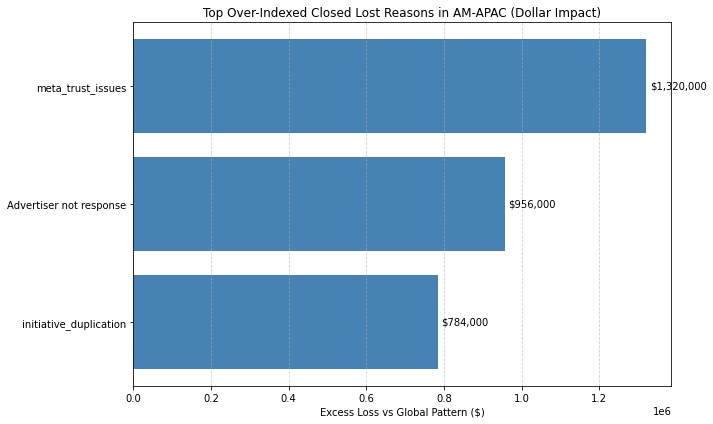

In [118]:
def plot_top_overindexed_reasons(new_columns_df: pd.DataFrame, focus_region: str, top_n: int = 5):
    """Plot the top over-indexed closed lost reasons for a given region."""
    # Filter the DataFrame for the focus region
    region_specific_df = new_columns_df.loc[focus_region]
    
    # Sort and select the top N reasons by excess loss
    top_df = region_specific_df.sort_values("excess_loss_$", ascending=True).tail(top_n)
    
    # Plot
    plt.figure(figsize=(10, 6))
    bars = plt.barh(top_df["reason"], top_df["excess_loss_$"], color="steelblue")
    plt.xlabel("Excess Loss vs Global Pattern ($)")
    plt.title(f"Top Over-Indexed Closed Lost Reasons in {focus_region} (Dollar Impact)")
    
    # Annotate bars with the excess loss value
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 10000, bar.get_y() + bar.get_height() / 2, f"${width:,.0f}", va='center')
    
    plt.tight_layout()
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()

plot_top_overindexed_reasons(new_columns_df, "AM-APAC", top_n=5)

In [72]:
from scipy.stats import zscore

In [73]:
df = pd.read_csv("../input/metrics_input/Mock_Vertical-Region_Closed_Won_Rates.csv")

In [74]:
# Version 1: Global baseline comparison (lift-based)
def vertical_fit_lift(df: pd.DataFrame, focus_region: str = "AM-NA", baseline_region: str = "Global") -> pd.DataFrame:
    pivot = df.pivot(index="vertical", columns="region", values="cli_closed_won_pct").reset_index()
    pivot["delta"] = pivot[focus_region] - pivot[baseline_region]
    pivot["lift"] = pivot[focus_region] / pivot[baseline_region]
    return pivot.sort_values("lift", ascending=False)

# Version 2: Z-score across regions (peer-relative)
def vertical_fit_zscore(df: pd.DataFrame, focus_region: str = "AM-NA") -> pd.DataFrame:
    peer_df = df[df["region"] != "Global"]
    grouped = peer_df.groupby("vertical")["cli_closed_won_pct"].transform(zscore)
    peer_df = peer_df.copy()
    peer_df["z_score"] = grouped
    return peer_df[peer_df["region"] == focus_region].sort_values("z_score", ascending=False)

# Run both analyses
lift_df = vertical_fit_lift(df)
zscore_df = vertical_fit_zscore(df)

result = pd.merge(lift_df[["vertical", "lift", "delta"]], zscore_df, on="vertical")
result = result.sort_values("lift", ascending=True)

In [75]:
lift_df

region,vertical,AM-APAC,AM-EMEA,AM-LATAM,AM-NA,Global,delta,lift
0,Pharma,0.022,0.025,0.021,0.045,0.028,0.017,1.607143
1,Retail,0.019,0.022,0.020,0.025,0.021,0.004,1.190476
2,Tech,0.021,0.020,0.018,0.018,0.022,-0.004,0.818182


In [76]:
zscore_df

,region,vertical,cli_closed_won_pct,pipeline_share,z_score
3,AM-NA,Pharma,0.045,0.1,1.712329
8,AM-NA,Retail,0.025,0.1,1.527525
13,AM-NA,Tech,0.018,0.1,-0.962250


In [77]:
result = pd.merge(lift_df[["vertical", "lift", "delta"]], zscore_df, on="vertical")
result = result.sort_values("lift", ascending=True)
result

,vertical,lift,delta,region,cli_closed_won_pct,pipeline_share,z_score
2,Tech,0.818182,-0.004,AM-NA,0.018,0.1,-0.962250
1,Retail,1.190476,0.004,AM-NA,0.025,0.1,1.527525
0,Pharma,1.607143,0.017,AM-NA,0.045,0.1,1.712329


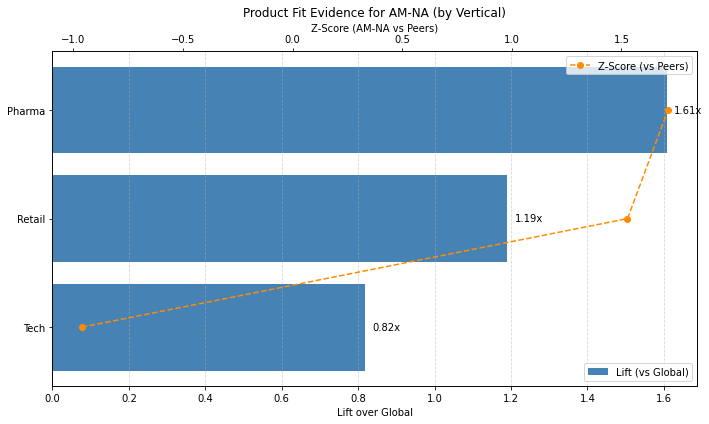

In [78]:
def product_fit_report(result: pd.DataFrame, focus_region: str = "AM-NA", baseline_region: str = "Global"):
    # Plot
    fig, ax1 = plt.subplots(figsize=(10, 6))
    bars = ax1.barh(result["vertical"], result["lift"], color="steelblue", label="Lift (vs Global)")
    for i, (lift, z) in enumerate(zip(result["lift"], result["z_score"])):
        ax1.text(lift + 0.02, i, f"{lift:.2f}x", va="center")

    ax2 = ax1.twiny()
    ax2.plot(result["z_score"], result["vertical"], "o--", color="darkorange", label="Z-Score (vs Peers)")

    ax1.set_xlabel(f"Lift over {baseline_region}")
    ax2.set_xlabel("Z-Score (AM-NA vs Peers)")
    ax1.set_title(f"Product Fit Evidence for {focus_region} (by Vertical)")
    ax1.grid(axis='x', linestyle='--', alpha=0.5)
    ax1.legend(loc="lower right")
    ax2.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

    return result

# Run on mock data
fit_df = product_fit_report(result)

In [92]:
def select_mix(df_region, method='percentile', percentile=0.75, impact_top_n=2):
    """
    Return a boolean mask over df_region indicating which verticals to consider
    based on mix:
    - percentile: keep pipeline_share >= given percentile
    - impact: keep top N by (cli_pct - baseline_pct) * pipeline_share
    """
    if method == 'percentile':
        thresh = df_region['pipeline_share'].quantile(percentile)
        return df_region['pipeline_share'] >= thresh
    elif method == 'impact':
        df_copy = df_region.copy()
        df_copy['impact'] = (
            (df_copy['cli_closed_won_pct'] - df_copy['baseline_pct'])
            * df_copy['pipeline_share']
        )
        top_verticals = df_copy.nlargest(impact_top_n, 'impact')['vertical']
        return df_region['vertical'].isin(top_verticals)
    else:
        raise ValueError("method must be 'percentile' or 'impact'")

def calculate_fit_metrics(
    df, region,
    mix_method='percentile', percentile=0.75, impact_top_n=2,
    lift_thresh=1.2, inv_lift_thresh=0.8, zscore_thresh=1.0
):
    """
    Compute lift, z-score, mix filter, and direction for a given region.
    """
    baseline = df[df.region == 'Global'][['vertical','cli_closed_won_pct']] \
                 .rename(columns={'cli_closed_won_pct':'baseline_pct'})
    work = df[df.region == region].merge(baseline, on='vertical')
    peer = df[df.region != 'Global'].groupby('vertical')['cli_closed_won_pct'] \
               .agg(mean='mean', std='std').reset_index()
    work = work.merge(peer, on='vertical')
    work['lift'] = work['cli_closed_won_pct'] / work['baseline_pct']
    work['zscore'] = (work['cli_closed_won_pct'] - work['mean']) / work['std']
    mix_mask = select_mix(
        work, method=mix_method,
        percentile=percentile, impact_top_n=impact_top_n
    )
    cond_pos = mix_mask & (work.lift >= lift_thresh) & (work.zscore >= zscore_thresh)
    cond_neg = mix_mask & (work.lift <= inv_lift_thresh) & (work.zscore <= -zscore_thresh)
    work['direction'] = np.where(cond_pos, 'positive',
                         np.where(cond_neg, 'negative', 'neutral'))
    work['mix_filter'] = mix_mask
    return work

# Define generate_insights function first
def generate_insights(df_metrics, template_str):
    """
    Auto-generate insights: dynamically map all available fields.
    """
    insights = []
    for r in df_metrics.itertuples(index=False):
        fields = r._asdict()
        fields['region_pct'] = f"{fields['cli_closed_won_pct']:.1%}"
        fields['baseline_pct'] = f"{fields['baseline_pct']:.1%}"
        fields['lift'] = f"{fields['lift']:.2f}"
        fields['zscore'] = f"{fields['zscore']:.2f}"
        fields['mix'] = f"{fields['pipeline_share']:.0%}"
        if fields.get('mix_filter', True):
            insights.append(template_str.format(**fields))
    return insights

def plot_fit(df_metrics, region):
    """
    Plot bubble chart for a region's fit metrics.
    """
    sub = df_metrics[df_metrics.region == region]
    plt.figure(figsize=(6,4))
    plt.scatter(
        sub.zscore, sub.lift,
        s=sub.pipeline_share * 1000,
        c=sub.direction.map({'positive':'green','negative':'red','neutral':'gray'}),
        alpha=0.7
    )
    for r in sub.itertuples():
        plt.text(r.zscore, r.lift, r.vertical, ha='center', va='center')
    plt.axvline(1.0, ls='--'); plt.axhline(1.0, ls='--')
    plt.xlabel('Z-score vs peers'); plt.ylabel('Lift vs global')
    plt.title(f'{region} Vertical Fit Analysis')
    plt.tight_layout()
    plt.show()

In AM-NA, CLI Closed Won rate in Retail is 2.5% vs 2.1% globally (Lift: 1.19x, Z-score: 1.32).
This signals neutral fit in this vertical.


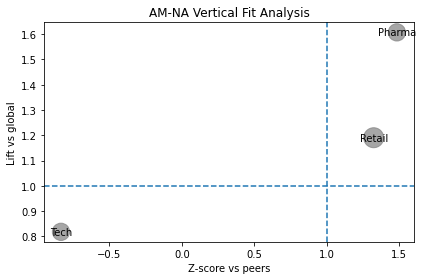

In [94]:
df = pd.read_csv("../input/metrics_input/Mock_Vertical-Region_Closed_Won_Rates.csv")
template = """
In {region}, CLI Closed Won rate in {vertical} is {region_pct} vs {baseline_pct} globally (Lift: {lift}x, Z-score: {zscore}).
This signals {direction} fit in this vertical.
""".strip()

# Percentile method
metrics_pct = calculate_fit_metrics(df, 'AM-NA', mix_method='percentile', percentile=0.75)
insights_pct = generate_insights(metrics_pct, template)
for line in insights_pct:
    print(line)
plot_fit(metrics_pct, 'AM-NA')

In AM-NA, CLI Closed Won rate in Pharma is 4.5% vs 2.8% globally (Lift: 1.61x, Z-score: 1.48).
This signals positive fit in this vertical.
In AM-NA, CLI Closed Won rate in Retail is 2.5% vs 2.1% globally (Lift: 1.19x, Z-score: 1.32).
This signals neutral fit in this vertical.


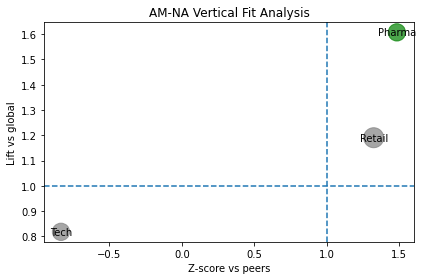

In [95]:
# Impact method
metrics_imp = calculate_fit_metrics(df, 'AM-NA', mix_method='impact', impact_top_n=2)
insights_imp = generate_insights(metrics_imp, template)
for line in insights_imp:
    print(line)
plot_fit(metrics_imp, 'AM-NA')